## Homework: Accumulation Opportunity
### 25th January, 2023

In [1]:
import sys
sys.version

'3.10.8 (main, Nov 24 2022, 08:09:04) [Clang 14.0.6 ]'

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.xkcd()

import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import plotnine as p9
import statsmodels.api as sm
import math
import csv
import datetime as dt

pd.options.mode.chained_assignment = None 

## Introduction

In this study, I'm implementing an accumulation algorithm, which aims at increasing or decreasing portfolio positions some large amount Q without incurring the debilitating costs of executing the entire transaction at once.

## Data

We assess the feasibility of accumulating large positions while attempting to maintain low trading costs in an electronic market. Here I'm using the cryptotoken and traditional currency pair of **BTC-USD**, and the nanoseconds data is selected from a few days in 2021, 2022 and 2023.

#### Functions

In [336]:
def load_trade_data(path, name):
    
    dtypes = {"timestamp_utc_nanoseconds": int, "PriceMillionths": int, "SizeBillionths": int, "Side": int}
    
    df = pd.read_csv(path, delimiter = "\t", usecols=dtypes.keys(), dtype=dtypes)
    df.timestamp_utc_nanoseconds = pd.to_datetime(df.timestamp_utc_nanoseconds)
    df = df.set_index("timestamp_utc_nanoseconds")
    
    df.name = name
    
    return df

def process_data(df):

    df['SizeBillionths'] = df['SizeBillionths']/1000000000
    df['PriceMillionths'] = df['PriceMillionths']/1000000

    df = df.rename(columns={'SizeBillionths': 'Size', 'PriceMillionths': 'Price'})

    df = df.dropna()

    return df

#### Load data

In [329]:
df_2021_ = load_trade_data("data/2021/trades_narrow_BTC-USD_2021.delim.gz", "BTC-USD-2021")
df_2022_ = load_trade_data("data/2022/trades_narrow_BTC-USD_2022.delim.gz", "BTC-USD-2022")
df_2023_ = load_trade_data("data/2023/trades_narrow_BTC-USD_2023.delim.gz", "BTC-USD-2023")

In [474]:
df_2021_.head()

,PriceMillionths,SizeBillionths,Side
timestamp_utc_nanoseconds,,,
2021-04-10 21:28:52.515484,59120.71,0.009701,-1
2021-04-10 21:28:52.515484,59125.07,0.008122,-3
2021-04-10 21:28:52.989553,59119.95,0.006564,-1
2021-04-10 21:28:52.989553,59125.07,0.000614,-1
2021-04-10 21:28:53.074765,59119.95,0.016996,-1


In [337]:
df_2021 = process_data(df_2021_)
df_2022 = process_data(df_2022_)
df_2023 = process_data(df_2023_)

In [473]:
df_2021.head()

,Price,Size,Side
timestamp_utc_nanoseconds,,,
2021-04-10 21:28:52.515484,59120.71,0.009701,-1
2021-04-10 21:28:52.515484,59125.07,0.008122,-3
2021-04-10 21:28:52.989553,59119.95,0.006564,-1
2021-04-10 21:28:52.989553,59125.07,0.000614,-1
2021-04-10 21:28:53.074765,59119.95,0.016996,-1


#### Analysis

We are going to have a brief analysis for the amount of trading volume in market in different years. The reason is that we are going to implement the following VWAP strategy based on market activity. We are also going to determine the target quantity Q we are to trade with the observations of trading volume in market, so we could set a reasonable goal which we could achieve. 

We can as well use historical data to estimate the amount of trading volume to come, and construct a tradeoff between the cost of trading and the time to finish trading accordingly.

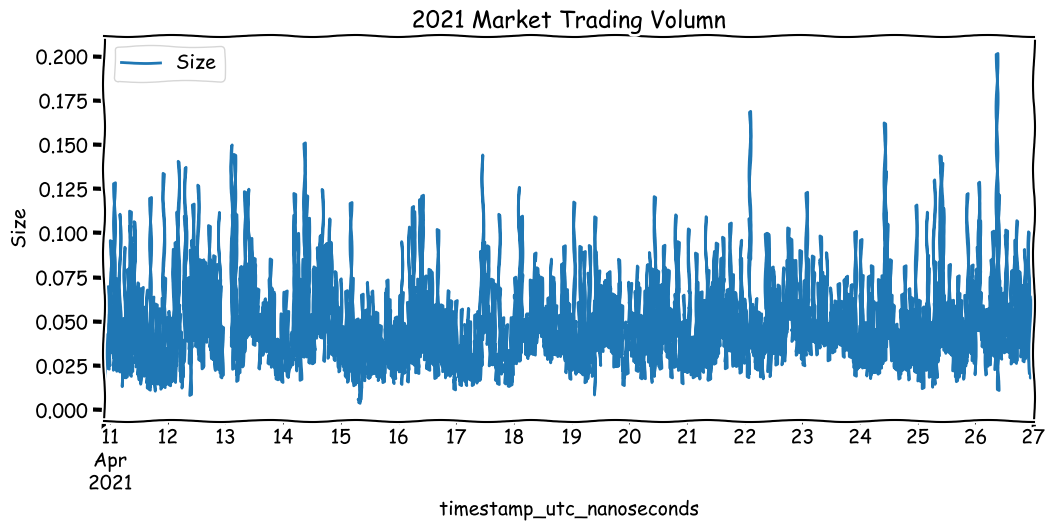

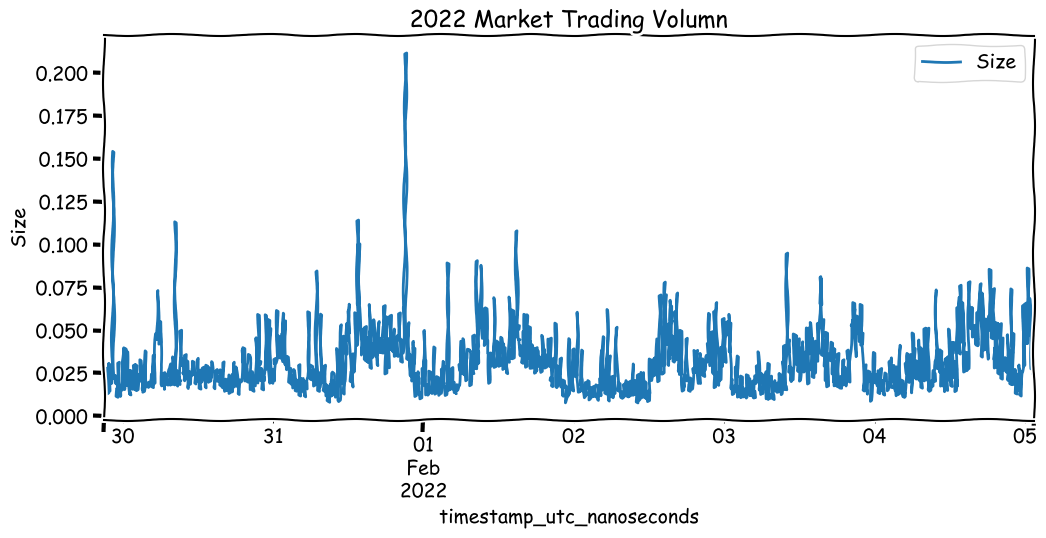

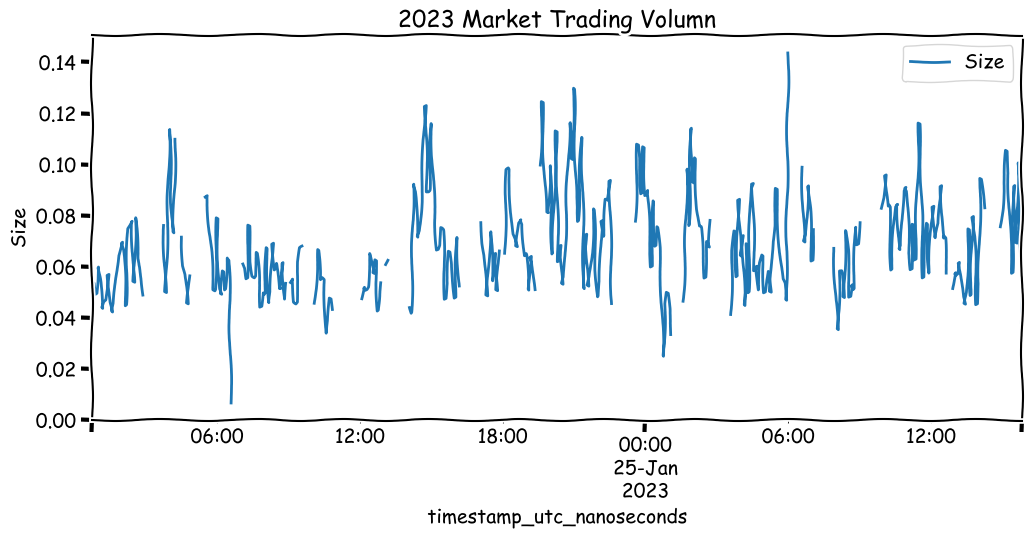

In [339]:
df_2021_minute = df_2021.resample('5Min')['Size'].mean().to_frame()
df_2021_minute.plot(title= "2021 Market Trading Volumn", ylabel = "Size" ,figsize = (12,5));

df_2022_minute = df_2022.resample('5Min')['Size'].mean().to_frame()
df_2022_minute.plot(title= "2022 Market Trading Volumn", ylabel = "Size" ,figsize = (12,5));

df_2023_minute = df_2023.resample('5Min')['Size'].mean().to_frame()
df_2023_minute.plot(title= "2023 Market Trading Volumn", ylabel = "Size" ,figsize = (12,5));

In [319]:
market_volume_summary = []
market_volume_summary.append(['2021', len(df_2021), df_2021['Size'].mean(),df_2021['Size'].max(),df_2021['Size'].min()])
market_volume_summary.append(['2022', len(df_2022), df_2022['Size'].mean(),df_2022['Size'].max(),df_2022['Size'].min()])
market_volume_summary.append(['2023', len(df_2023), df_2023['Size'].mean(),df_2023['Size'].max(),df_2023['Size'].min()])
market_volume_summary = pd.DataFrame(market_volume_summary, columns=['Year', 'Amount of sample','Mean','Max','Min'])
market_volume_summary = market_volume_summary.set_index('Year')
market_volume_summary

,Amount of sample,Mean,Max,Min
Year,,,,
2021,6268838,0.048130,81.091353,1.000000e-08
2022,2907376,0.034531,87.745783,1.000000e-08
2023,560107,0.071646,27.441000,1.000000e-08


According to the graph, we could tell that the market is more active in April comparing with February 2022, the market trading volume is also more stable over the period. The dataset in 2023 is siginificantly smaller and missing.

## VWAP Participation Algorithm

In this algorithm, we are trying to place a large order, that is, to buy or sell a large target quantity Q within a time period, here we set the goal of finishing the trading in 15 minutes. 

We achieve our goal with **VWAP strategy (volume-weighted average price)**. a VWAP strategy attempts to “participate” in market trading by placing (small) orders frequently when the market is active, and less frequently when it is not.

#### Functions

In [340]:
def market_data(df,Q):
    
    if Q > 0:
        
        df_side = df[df['Side'] > 0]
        df_price_millionths = df_side.groupby('timestamp_utc_nanoseconds')['Price'].max().to_frame()
        
    if Q < 0:
        
        df_side = df[df['Side'] < 0]
        df_price_millionths = df_side.groupby('timestamp_utc_nanoseconds')['Price'].min().to_frame()
        
    
    df_size_billionths = df_side.groupby('timestamp_utc_nanoseconds')['Size'].sum().to_frame()
    df_market = df_size_billionths.join(df_price_millionths)
    
    return df_market

In [377]:
def accumulation(df,Q,p,random_state = -1, plot_show = False, warning = False):

    df_market = market_data(df,Q)
    
    # randomly select start time/arrival time
    
    period_end_time = df_market.index[-1]
    
    while(1):

        if random_state == -1:
            arrival_time = df_market.sample().index.tolist()[0]
        else:
            arrival_time = df_market.sample(random_state = random_state).index.tolist()[0]
        expect_end_time = arrival_time + dt.timedelta(minutes=15)
        
        if expect_end_time <= period_end_time:
            
            df_trade = df_market.loc[arrival_time:expect_end_time]
            real_end_time = df_trade.index[-1]

            if real_end_time.minute == expect_end_time.minute and real_end_time.minute == expect_end_time.minute:
                break   # to make sure the sample is a continuous period of 15 minutes
    
    # trade

    # df_trade = df_trade.dropna()

    # df_trade['SizeBillionths'] = df_trade['SizeBillionths']/1000000000
    # df_trade['PriceMillionths'] = df_trade['PriceMillionths']/1000000

    # df_trade = df_trade.rename(columns={'SizeBillionths': 'Size', 'PriceMillionths': 'Price'})

    df_trade['V'] = df_trade['Size'] * p
    df_trade['CumulativeV'] = df_trade['V'].cumsum()

    if Q > 0.0:
        df_trade['Q'] = Q
    else:
        df_trade['Q'] = Q * (-1)

    df_trade['Q'] = df_trade['Q'] - df_trade['CumulativeV']

    # print(df_trade)

    if df_trade.iloc[-1]['Q'] <= 0.0:

        if df_trade.iloc[0]['Q'] > 0.0:

            index1 = df_trade.index[df_trade['Q'] > 0.0].tolist()[-1]
            index2 = df_trade.index[df_trade['Q'] <= 0.0].tolist()[0]
            i2 = df_trade.index.get_loc(index2)
            i1 = df_trade.index.get_loc(index1)

        else:
            
            i1 = 0
            i2 = 1
            index1 = df_trade.index[0]
            index2 = df_trade.index[1]

        remain_Q = df_trade.iloc[i1]['Q']
        df_trade.loc[index1]['V'] = remain_Q

        df_trade.loc[index2:, 'V'] = 0
        df_trade.loc[index2:, 'Q'] = 0

        df_trade['CumulativeV'] = df_trade['V'].cumsum()

        df_trade['PV'] = (df_trade['V'] * df_trade['Price'])
        df_trade['CumulativePV'] = df_trade['PV'].cumsum()

        df_trade['VWAP'] = df_trade['CumulativePV']/df_trade['CumulativeV']

        if plot_show == True:
            # plt.plot(df_trade.iloc[0:i2+100]['VWAP'])

            df_trade.iloc[0:i2+100]['VWAP'].plot(title= "Volume-Weighted Average Price", 
            ylabel = "Price", xlabel = "Time", figsize = (12,5));

        return df_trade, 1

    else:

        if warning == True:
            print("Trading time exceeded.")

        return df_trade, 0

#### Implement the algorithm

* **Step1:** Since the simulation function should use actual signed trading volumes to judge simulated accumulation and make the conservative assumption that, in a flurry of trades trading through several levels, only the worst of those was "qualifying", we select the highest price of the same tick as the price we are going to use if Q is positive, and the lowest price if Q is negative.

* **Step2:** We select the arrival time at random (and have made sure that there is a continuous period of 15 minutes coming after the arrival time).

* **Step3:** Trade a volume at each tick based on the market volume and participation rate to see if the target quantity Q could be fulfilled in 15 minutes, and return the result.

Below are two examples of using the VWAP participation algorithm to trade quantity Q successfully and unsuccessfully. The target quantity Q is decided based on the analysis results of market trading volume data.

,Size,Price,V,CumulativeV,Q,PV,CumulativePV,VWAP
timestamp_utc_nanoseconds,,,,,,,,
2021-04-22 15:21:10.663939,0.001578,54563.89,0.000016,0.000016,0.001484,0.861264,0.861264,54563.890000
2021-04-22 15:21:11.991638,0.000173,54563.89,0.000002,0.000018,0.001482,0.094630,0.955894,54563.890000
2021-04-22 15:21:12.672286,0.017970,54563.89,0.000180,0.000197,0.001303,9.804924,10.760818,54563.890000
2021-04-22 15:21:14.640123,0.001769,54539.67,0.000018,0.000215,0.001285,0.964916,11.725733,54561.896113
2021-04-22 15:21:15.044109,0.000638,54539.67,0.000006,0.000221,0.001279,0.348105,12.073838,54561.255051
...,...,...,...,...,...,...,...,...
2021-04-22 15:36:07.830144,0.000164,54549.21,0.000000,0.001454,0.000000,0.000000,79.301294,54526.145391
2021-04-22 15:36:08.697242,0.001771,54549.30,0.000000,0.001454,0.000000,0.000000,79.301294,54526.145391
2021-04-22 15:36:09.376028,0.089916,54549.30,0.000000,0.001454,0.000000,0.000000,79.301294,54526.145391


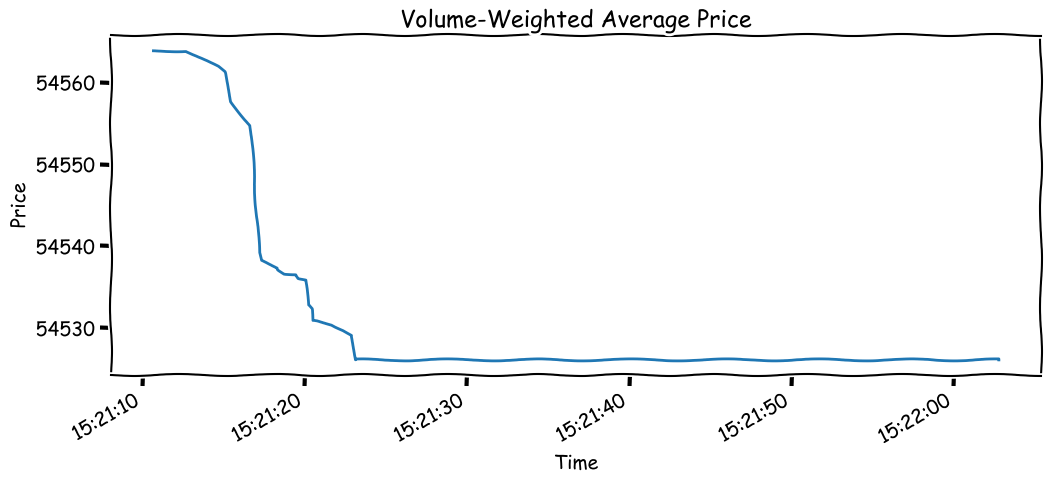

In [371]:
# Example 1

Q = 1.5e-3
p = 0.01

df_trade, success = accumulation(df_2021, Q, p, random_state = 3825968, plot_show=True)
df_trade

,Size,Price,V,CumulativeV,Q,PV,CumulativePV,VWAP
timestamp_utc_nanoseconds,,,,,,,,
2022-02-03 19:59:44.353359,0.000195,36569.16,3.897600e-08,3.897600e-08,0.002500,0.001425,0.001425,36569.160000
2022-02-03 19:59:44.357248,0.000274,36569.16,5.480800e-08,9.378400e-08,0.002500,0.002004,0.003430,36569.160000
2022-02-03 19:59:45.016666,0.000277,36567.94,5.546400e-08,1.492480e-07,0.002500,0.002028,0.005458,36568.706620
2022-02-03 19:59:45.232605,0.013358,36566.04,2.671682e-06,2.820930e-06,0.002497,0.097693,0.103151,36566.181084
2022-02-03 19:59:48.630803,0.000313,36572.59,6.260000e-08,2.883530e-06,0.002497,0.002289,0.105440,36566.320218
...,...,...,...,...,...,...,...,...
2022-02-03 20:14:38.715860,0.296451,36595.52,0.000000e+00,2.494526e-03,0.000000,0.000000,91.206728,36562.750322
2022-02-03 20:14:40.405747,0.000101,36597.64,0.000000e+00,2.494526e-03,0.000000,0.000000,91.206728,36562.750322
2022-02-03 20:14:41.512854,0.000062,36597.75,0.000000e+00,2.494526e-03,0.000000,0.000000,91.206728,36562.750322


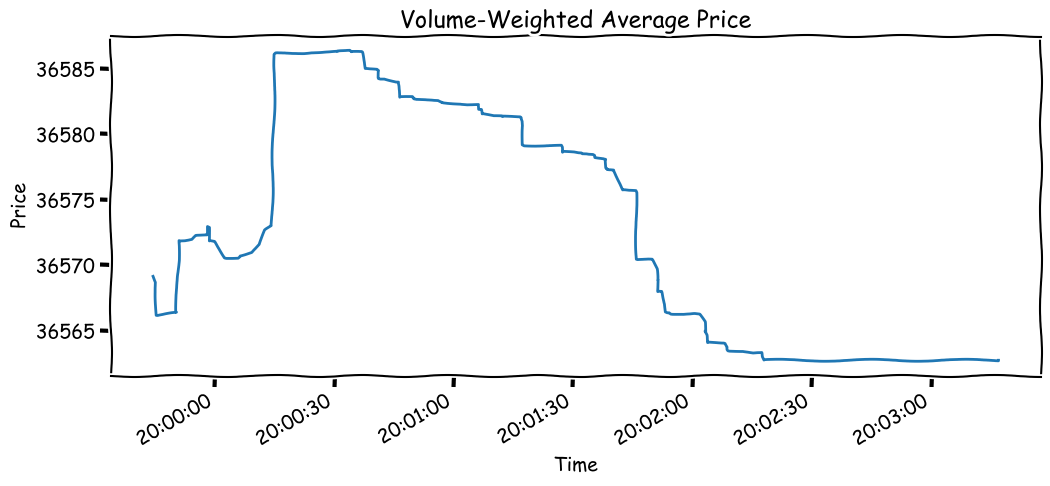

In [372]:
# Example 2

Q = -2.5e-3
p = 0.0002 # 0.001 0.0001

df_trade, success = accumulation(df_2022, Q, p, random_state = 36, plot_show=True)
df_trade

In [373]:
# Example 3

Q = 2.5e-3
p = 0.00005

df_trade, success = accumulation(df_2022, Q, p, random_state = 5, warning = True)

Trading time exceeded.


## Analysis

To assess and contrast the accumulation opportunities available in cryptotoken markets, I did following analysis.

* Relationship between Q and the likelihood of completing the entire quantity.

* Relationship between p and the likelihood of completing the entire quantity.

* Compare average price of accumulated positions to arrival prices.

* Adjust p according to market activity.

#### Relationship between Q and the likelihood of completing the entire quantity

Fix participation value p, change the target quantity Q, and sample multiple times to see the probability of completing the entire quantity within 15 minutes.

In [396]:
def calculate_success_rate(df, num, Q, p):

    success_count = 0

    for i in range(num):
        
        df_trade, success = accumulation(df_2021, Q, p)
        success_count += success

    return success_count/num

In [387]:
Q_list = [2, 1.5, 1, 5e-1, 7e-1, 5e-2]
p = 0.01

success_rate_2021 = []
success_rate_2022 = []
success_rate_2023 = []

for Qi in Q_list:

    success_rate_2021.append(calculate_success_rate(df_2021, 20, Q = Qi, p = p))
    success_rate_2022.append(calculate_success_rate(df_2022, 20, Q = Qi, p = p))
    success_rate_2023.append(calculate_success_rate(df_2023, 20, Q = Qi, p = p))

In [398]:
Q_summary = pd.DataFrame(list(zip(Q_list,success_rate_2021,success_rate_2022,success_rate_2023)), columns=['Q', '2021','2022','2023'])
Q_summary = Q_summary.set_index('Q')
Q_summary = Q_summary.sort_index()
Q_summary

,2021,2022,2023
Q,,,
0.05,1.00,1.00,1.00
0.50,0.75,1.00,0.80
0.70,0.80,0.55,0.65
1.00,0.65,0.40,0.35
1.50,0.30,0.40,0.35
2.00,0.20,0.15,0.35


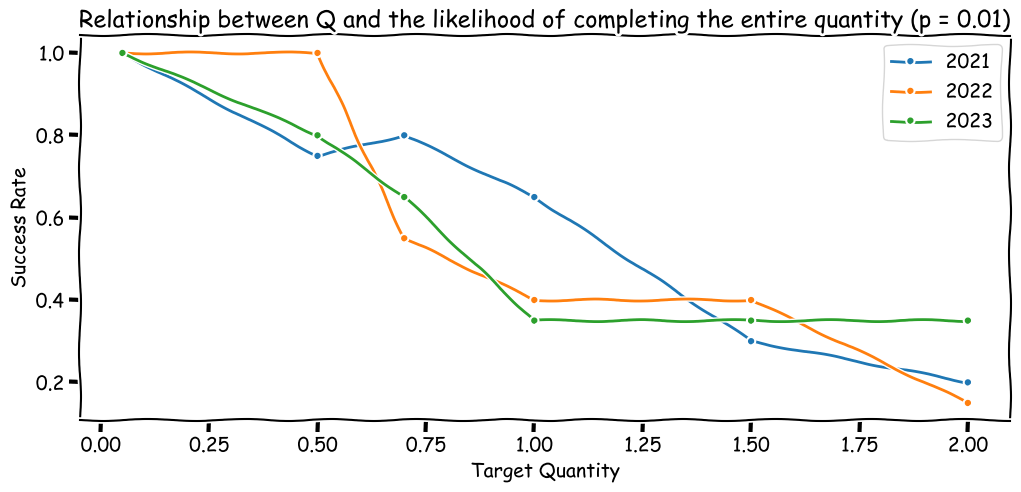

In [403]:
Q_summary.plot(title= "Relationship between Q and the likelihood of completing the entire quantity (p = 0.01)", 
ylabel = "Success Rate", xlabel = "Target Quantity", figsize = (12,5),style='.-');

When participation rate p is fixed, the larger the target quantity Q, the lower the success rate of completing the transaction within 15 minutes, which can be observed in three datasets.

#### Relationship between p and the likelihood of completing the entire quantity

In [404]:
Q = 1.5e-3
p_list = [0.01, 0.005, 0.0001, 0.00005, 0.00001]

success_rate_2021 = []
success_rate_2022 = []
success_rate_2023 = []

for pi in p_list:

    success_rate_2021.append(calculate_success_rate(df_2021, 20, Q = Q, p = pi))
    success_rate_2022.append(calculate_success_rate(df_2022, 20, Q = Q, p = pi))
    success_rate_2023.append(calculate_success_rate(df_2023, 20, Q = Q, p = pi))

In [406]:
p_list1 = [0.00004, 0.000035, 0.00003, 0.000025, 0.00002]

for pi in p_list1: 

    success_rate_2021.append(calculate_success_rate(df_2021, 20, Q = Q, p = pi))
    success_rate_2022.append(calculate_success_rate(df_2022, 20, Q = Q, p = pi))
    success_rate_2023.append(calculate_success_rate(df_2023, 20, Q = Q, p = pi))

In [412]:
p_summary = pd.DataFrame(list(zip(p_list+p_list1,success_rate_2021,success_rate_2022,success_rate_2023)), columns=['p', '2021','2022','2023'])
p_summary = p_summary.set_index('p')
p_summary = p_summary.sort_index()
p_summary

,2021,2022,2023
p,,,
0.000010,0.20,0.30,0.35
0.000020,0.75,0.60,0.75
0.000025,0.85,0.85,0.65
0.000030,0.90,0.85,0.90
0.000035,0.90,0.90,0.90
0.000040,1.00,0.90,1.00
0.000050,1.00,1.00,0.95
0.000100,1.00,1.00,1.00
0.005000,1.00,1.00,1.00


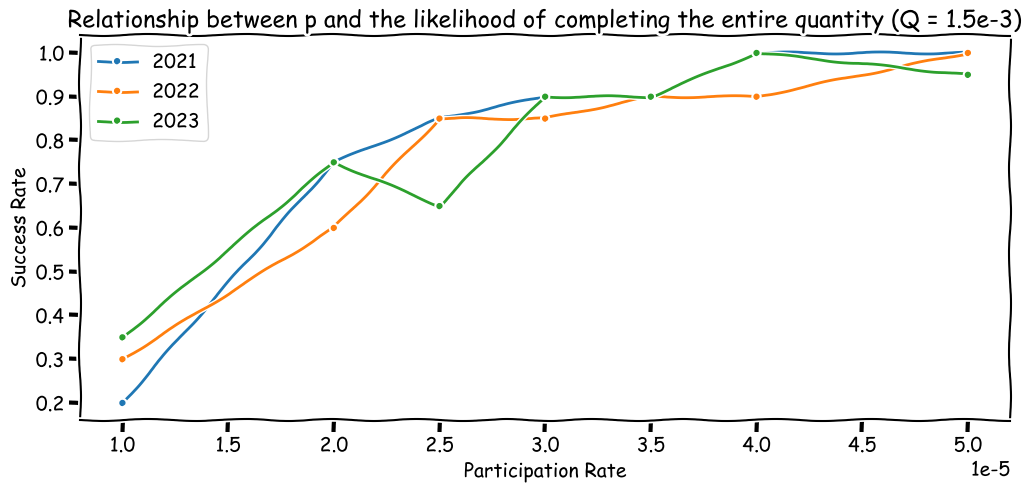

In [416]:
p_summary.iloc[0:7].plot(title= "Relationship between p and the likelihood of completing the entire quantity (Q = 1.5e-3)", 
ylabel = "Success Rate", xlabel = "Participation Rate", figsize = (12,5),style='.-');

As expected, when target quantity Q is fixed, the larger the participation rate p, the higher the success rate of completing the transaction within 15 minutes, which can also be observed in three datasets.

#### Compare average price of accumulated positions to arrival price

We expect the VWAP by the end of the trading period could be lower than the price at the arrival time. By sampling and selecting arrival time at random, I observed that if the target quantity is fulfilled within 15 minutes, the volume-weighted average price either rises or falls during the period in most of cases. As a result, the following discussion is aimed at finding out if the participation rate p would effect the difference between average price of accumulated positions and arrival price.

Below are two attempts to sample 50 times to compare the arrival time price and average price of accumulated positions.

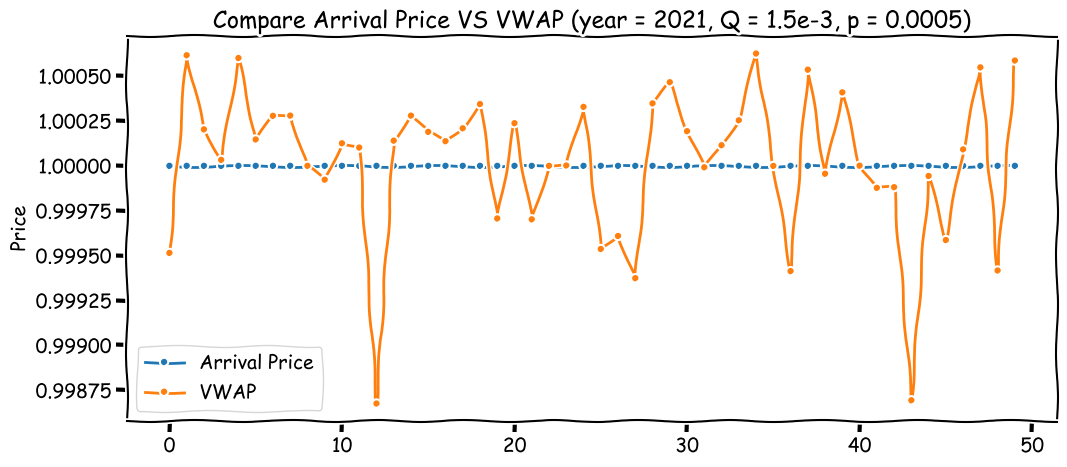

In [457]:
# Attempt 1

Q = 1.5e-3
p = 0.0005

price_list = []
vwap_list = []

count = 0

while count != 50:

    df_trade, success = accumulation(df_2021, Q, p)

    if success == 1:
        
        count += 1
        price_list.append(df_trade.iloc[0]['Price'])
        vwap_list.append(df_trade.iloc[-1]['VWAP'])

vwap_summary = pd.DataFrame(list(zip(price_list,vwap_list)), columns=['Arrival Price','VWAP'])
vwap_summary['VWAP'] = vwap_summary['VWAP']/vwap_summary['Arrival Price']
vwap_summary['Arrival Price'] = 1.0

vwap_summary.plot(title= "Compare Arrival Price VS VWAP (year = 2021, Q = 1.5e-3, p = 0.0005)", 
ylabel = "Price",figsize = (12,5),style='.-');

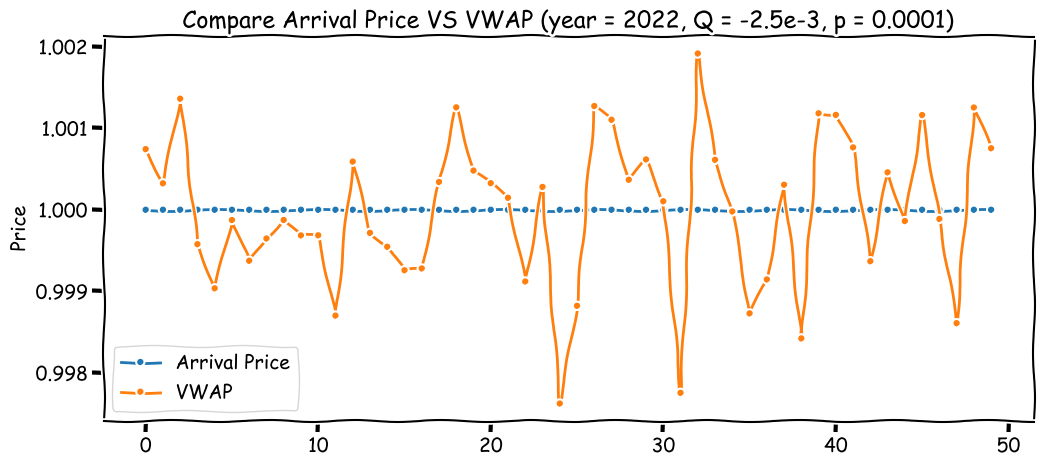

In [454]:
# Attempt 2

Q = -2.5e-3
p = 0.0001

price_list = []
vwap_list = []

count = 0

while count != 50:

    df_trade, success = accumulation(df_2022, Q, p)

    if success == 1:
        
        count += 1
        price_list.append(df_trade.iloc[0]['Price'])
        vwap_list.append(df_trade.iloc[-1]['VWAP'])


vwap_summary = pd.DataFrame(list(zip(price_list,vwap_list)), columns=['Arrival Price','VWAP'])
vwap_summary['VWAP'] = vwap_summary['VWAP']/vwap_summary['Arrival Price']
vwap_summary['Arrival Price'] = 1.0

vwap_summary.plot(title= "Compare Arrival Price VS VWAP (year = 2022, Q = -2.5e-3, p = 0.0001)", 
ylabel = "Price",figsize = (12,5),style='.-');

According to the above results and graph, the VWAP at the end of the trading period is not significantly higher or lower than the corresponding arrival price. We are going to select the data of 2022 and Q = 2.5e-3, to see if the change of p could influence VWAP.

In [458]:
Q = 2.5e-3
p_list = [0.0001, 0.0002, 0.0005, 0.001, 0.005, 0.01]

vwap_summary_list = []

for p in p_list:

    price_list = []
    vwap_list = []

    count = 0

    while count != 50:

        df_trade, success = accumulation(df_2022, Q, p)

        if success == 1:
            
            count += 1
            price_list.append(df_trade.iloc[0]['Price'])
            vwap_list.append(df_trade.iloc[-1]['VWAP'])

    vwap_summary = pd.DataFrame(list(zip(price_list,vwap_list)), columns=['Arrival Price','VWAP'])
    vwap_summary['VWAP'] = vwap_summary['VWAP']/vwap_summary['Arrival Price']
    vwap_summary['Arrival Price'] = 1.0

    vwap_summary_list.append(vwap_summary)

In [471]:
vwap_mean = []
vwap_std = []
vwap_winning_rate = []

for v in vwap_summary_list:
    vwap_mean.append(v['VWAP'].mean())
    vwap_std.append(v['VWAP'].std())
    vwap_winning_rate.append(v[v['VWAP']<1.0].count()['VWAP']/len(v))

vwap_summary_ = pd.DataFrame(list(zip(p_list, vwap_mean, vwap_std, vwap_winning_rate)), columns=['p','VWAP mean','VWAP std','VWAP winning rate'])
vwap_summary_ = vwap_summary_.set_index('p')
vwap_summary_ = vwap_summary_.sort_index()
vwap_summary_

,VWAP mean,VWAP std,VWAP winning rate
p,,,
0.0001,0.999848,0.001294,0.52
0.0002,0.999962,0.000784,0.52
0.0005,0.999946,0.000439,0.50
0.0010,0.999962,0.000308,0.54
0.0050,0.999893,0.000254,0.60
0.0100,0.999969,0.000185,0.38


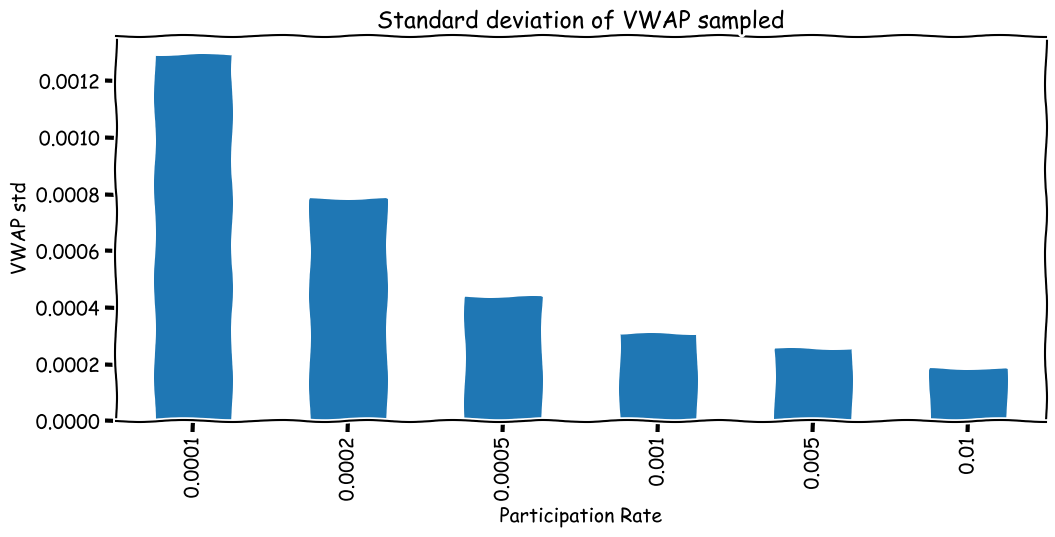

In [472]:
vwap_summary_['VWAP std'].plot(title= "Standard deviation of VWAP sampled", xlabel = "Participation Rate", 
ylabel = "VWAP std",figsize = (12,5),kind = 'bar');

I'm using winning rate to refer to the probability that the volume-weighted average price at the end of the period is lower than the arrival price. According to the above result, even though as participation rate changes, the winning rate and mean value of VWAP did not have a significant corresponding change, we did observed that the standard deviation value of VWAP decreased as participation rate gets larger. One of the reasons should be that when the participation rate increases, the target quantity can be satisfied faster, thus making the VWAP more stable.

## Possible improvements to the strategy

* **Change the participation rate according to market activity.** In our strategy we keep the participation rate the same when we randomly choose the arrival time. However, even though the datasets are in the same days, the trading volume of the market should vary throughout the day, for example, there might be more trading in the morning. As a result, we could change the participation rate accordingly. One of the methods is to look back the past half-an-hour historical data when we enter the market.

* **More sampling. We analyze the strategy by randomly choosing arrival times.** Due to time limit, the sample size selected is not very large. We might get more convincing statistical analysis results if we increase the number of samples.

## Conclusion

In this study, I implemented a VWAP participation algorithm and assessed the feasibility of accumulating large positions while attempting to maintain low trading costs in an electronic market. Discussions,analysis and results are as follows.

* We decide the reasonable target quantity by observing the amount of trading volume in market in different years. The market is more active in April comparing with February 2022.

* Despite the fact that market activity in BTC-USD datasets of 2021, 2022, and 2023 is not the same, we did not observe obvious differences in results when we implement the VWAP participation algorithm using different datasets.

* When participation rate p is fixed, the larger the target quantity Q, the lower the success rate of completing the transaction within the time period we want.

* When target quantity Q is fixed, the larger the participation rate p, the higher the success rate of completing the transaction.

* I compared average price of accumulated positions to arrival price, as participation rate p changes, the winning rate and mean value of VWAP sampled did not have a significant corresponding change. However, the standard deviation value of VWAP decreased as participation rate p gets larger, one of the reasons should be when p increases, Q can be satisfied faster, thus making the VWAP more stable between different selections of arrival times.